# Processor Data Analysis

This document contains debugging and exploratory information based on data collected as part of the CODEX processor CLI (saved as ```processor_data.json```) and is often helpful for the following:
- Tracking large (and possibly erroneous) drift compensations
- Viewing best focal plane selections for each region and tile (often useful for finding bad parts of a sample)
- Diagnosing over/under saturation in individual channels
- Examining execution times by operation

### Parameters

In [ ]:
# Parameters
processor_data_path = None

In [2]:
# Validation
assert processor_data_path is not None, 'Must set parameter for path to processor data json file'

### Load Processor Data

In [11]:
%matplotlib inline
from cytokit.ops import op, best_focus, deconvolution, drift_compensation, tile_summary, tile_generator
from cytokit.exec import read_processor_data
from IPython import display
import plotnine as pn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json

# Set expected keys for operations dynamically based on class names (to avoid
# future refactoring synchronization problems)
drift_comp_op = op.CytokitOp.get_op_for_class(drift_compensation.CytokitDriftCompensator)
best_focus_op = op.CytokitOp.get_op_for_class(best_focus.CytokitFocalPlaneSelector)
tile_summary_op = op.CytokitOp.get_op_for_class(tile_summary.CytokitTileSummary)
decon_op = op.CytokitOp.get_op_for_class(deconvolution.CytokitDeconvolution)
tile_gen_op = op.CytokitOp.get_op_for_class(tile_generator.CytokitTileGenerator)

# Load processor data as a dict of data frames, separated by operation type
data = read_processor_data(processor_data_path)

# Explicitly ignore tile generator stats
if tile_gen_op in data:
    del data[tile_gen_op]

In [12]:
# Display the head rows for each operation type
for k in data:
    display.display(data[k].head().style.set_caption(k))

,region_index,target_cycle,tile_index,tile_x,tile_y,translation
0,0,1,0,0,0,"[0, -1]"
1,0,2,0,0,0,"[0, -1]"
2,0,3,0,0,0,"[0, -1]"
3,0,4,0,0,0,"[0, -2]"
4,0,5,0,0,0,"[3, 0]"


,channel,max,mean,min,region_index,std,tile_index,tile_x,tile_y
0,HOECHST1,65535,19964.3,329,0,13839.3,0,0,0
1,CollagenIV,65535,1532.98,0,0,1712.91,0,0,0
2,CD7,30965,687.199,0,0,536.487,0,0,0
3,Ki67,65535,599.606,0,0,960.013,0,0,0
4,HOECHST2,17922,3813.52,0,0,2334.83,0,0,0


,region_index,slice,tile_index,tile_x,tile_y
0,0,"['slice(216, 1224, None)', 'slice(288, 1632, None)']",0,0,0
1,0,"['slice(216, 1224, None)', 'slice(288, 1632, None)']",1,1,0
2,0,"['slice(216, 1224, None)', 'slice(288, 1632, None)']",2,2,0
3,0,"['slice(216, 1224, None)', 'slice(288, 1632, None)']",3,3,0
4,0,"['slice(216, 1224, None)', 'slice(288, 1632, None)']",4,4,0


,best_z,classes,region_index,scores,tile_index,tile_x,tile_y
0,4,"[4, 6, 8, 9, 10, 9, 7, 4, 0]",0,"[4.375, 6.6822916667, 8.34375, 9.2552083333, 9.8958333333, 9.3177083333, 7.4947916667, 3.796875, 1.0572916667]",0,0,0
1,4,"[4, 6, 10, 9, 10, 10, 8, 6, 0]",0,"[3.4895833333, 6.6822916667, 8.515625, 9.3125, 9.8854166667, 9.703125, 8.6458333333, 4.3385416667, 1.2552083333]",1,1,0
2,4,"[4, 10, 10, 10, 10, 10, 8, 4, 0]",0,"[5.578125, 7.625, 9.0572916667, 9.515625, 9.921875, 9.5104166667, 7.6979166667, 2.640625, 0.5729166667]",2,2,0
3,4,"[4, 10, 10, 10, 10, 10, 8, 4, 0]",0,"[5.421875, 8.0885416667, 9.3177083333, 9.6875, 9.9739583333, 9.75, 8.5416666667, 3.5052083333, 0.6041666667]",3,3,0
4,4,"[8, 10, 10, 10, 10, 10, 7, 1, 0]",0,"[6.3958333333, 8.3854166667, 9.453125, 9.8020833333, 9.9895833333, 9.5989583333, 7.28125, 1.625, 0.4583333333]",4,4,0


### Drift Compensation Summary

Text(0.5,1,'Drift Compensation Translation by Region/Cycle')

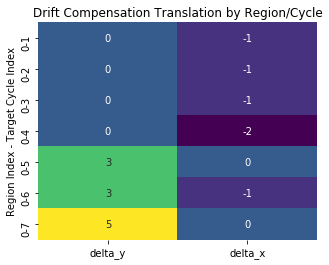

In [16]:
df = data[drift_comp_op].copy()
dims = ['z', 'y', 'x'][-len(df['translation'].iloc[0]):]
df = df.groupby(['region_index', 'target_cycle'])['translation'].first().reset_index()
for i, dim in enumerate(dims):
    df['delta_' + dim] = df['translation'].apply(lambda v: v[i])

sns.heatmap(
    df.set_index(['region_index', 'target_cycle']).drop('translation', axis=1),
    annot=True, cmap='viridis',
    yticklabels=1, cbar=False
)
plt.gcf().set_size_inches(5, 4 * df['region_index'].nunique())
plt.gca().set_ylabel('Region Index - Target Cycle Index')
plt.gca().set_title('Drift Compensation Translation by Region/Cycle')

### Focal Plane Summary

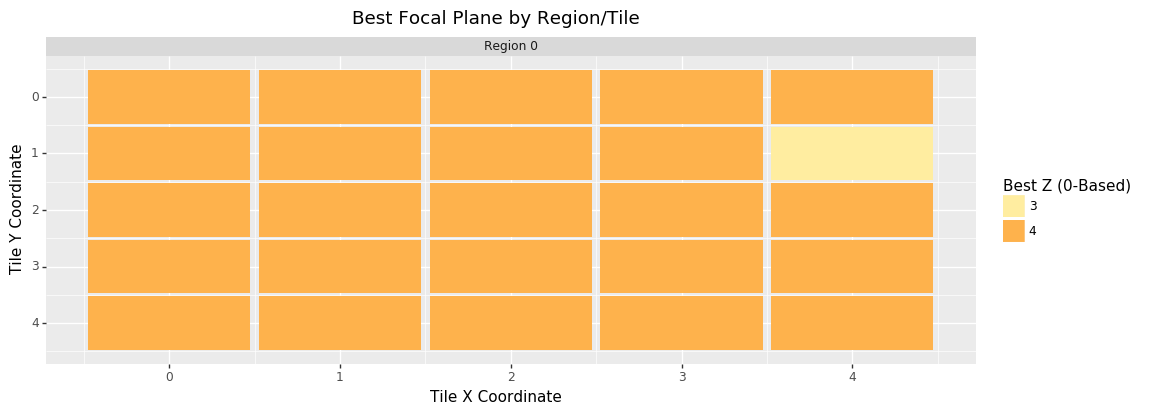

<ggplot: (8752782792533)>

In [19]:
df = data[best_focus_op].copy()
(
    pn.ggplot(
        df.assign(
            z=df['best_z'].apply(lambda v: '{}'.format(v)),
            region_index=df['region_index'].apply(lambda v: 'Region {}'.format(v))
        ), 
        pn.aes(x='tile_x', y='tile_y', fill='z', width=.95, height=.95)
    ) +
    pn.scale_y_reverse() +
    pn.scale_fill_brewer(palette='YlOrRd', guide=pn.guide_legend(title='Best Z (0-Based)')) +
    pn.facet_wrap('~region_index', ncol=2) +
    pn.geom_tile() + 
    pn.xlab('Tile X Coordinate') +
    pn.ylab('Tile Y Coordinate') +
    pn.ggtitle('Best Focal Plane by Region/Tile') +
    pn.theme(figure_size=(12, 4 * (df['region_index'].nunique() + 1) // 2))
)

### Tile Summary Statistics

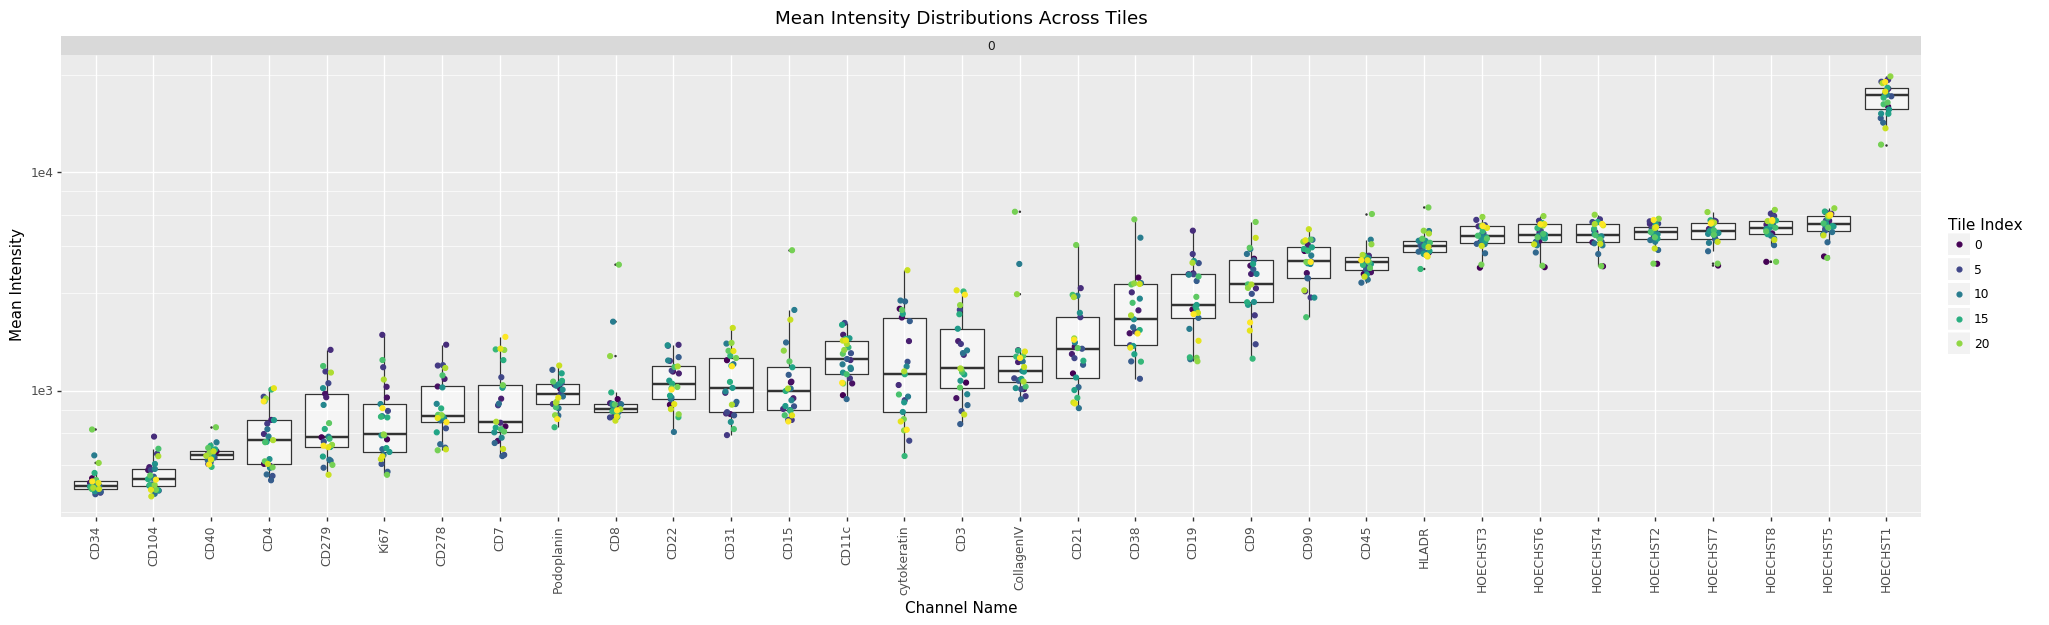

<ggplot: (8752782716150)>

In [22]:
df = data[tile_summary_op].copy()
(
    pn.ggplot(
        df.assign(
            region=df['region_index'].apply(lambda v: 'Region {}'.format(v)),
            channel=pd.Categorical(
                df['channel'],
                categories=df.groupby('channel')['mean'].mean().sort_values().index, ordered=True
            )
        ), 
        pn.aes(x='channel', y='mean')
    ) + 
    pn.geom_boxplot(outlier_size=0, alpha=.5) +
    pn.geom_jitter(pn.aes(color='tile_index'), width=.1) +
    pn.scale_y_log10() +
    pn.scale_color_continuous(guide=pn.guide_legend(title='Tile Index')) +
    pn.facet_wrap('~region_index', ncol=2) +
    pn.theme(figure_size=(24, 6 * (df['region_index'].nunique() + 1) // 2), axis_text_x=pn.element_text(rotation=90)) +
    pn.ggtitle('Mean Intensity Distributions Across Tiles') +
    pn.xlab('Channel Name') +
    pn.ylab('Mean Intensity')
)